In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carga del dataset

Utilizando spark se realizo una partición del 2.5% de los datos del dataset original.

In [6]:
with open("header.txt", "r") as f:
    line = f.readline()
    cols = line.split(",")
    
df = pd.read_csv("data_sample.csv", header = None, sep = ",", names = cols)
df.head()

,periodo,id_cli,fecha_nacimiento,edad,genero,estado_civil,nivel_academico,profesion,ocupacion,tipo_vivienda,...,cuota_libranza_sf,cant_oblig_tot_sf,cant_cast_ult_12m_sr,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,202003,2089776,19840630,35.638604,M,DIVORCIADO,TECNOLOGO,TECNOLOGIA SISTEMAS,Empleado,ALQUILADA,...,0.0,0.0,0.0,695516.000,C,0.0,\N,1255032.0,NaN,304687.00
1,201902,2088089,19860727,32.476386,M,UNION LIBRE,NO INFORMA,\N,Independiente,FAMILIAR,...,0.0,NaN,NaN,1187025.000,SIN INFO,NaN,\N,NaN,NaN,187990.00
2,202001,3892351,19910108,28.936345,M,SOLTERO,TECNOLOGO,OTROS,Independiente,\N,...,0.0,NaN,NaN,3879251.250,SIN INFO,NaN,\N,NaN,NaN,862348.92
3,202008,2897552,19900903,29.883641,M,SOLTERO,BACHILLER,\N,Empleado,\N,...,0.0,0.0,1.0,210681.475,F,7.0,\N,NaN,1484205.0,1056864.00
4,202001,4782141,19790623,40.481862,F,NO INFORMA,SIN INFORMACION,\N,Empleado,\N,...,0.0,4.0,0.0,1615755.800,C,0.0,70831,4353538.0,3500000.0,248386.00


### Las siguientes variables no serán utilizadas dado que no aportan información relevante para el problema



In [7]:
df = df.drop(["periodo","id_cli","fecha_nacimiento","ult_actual","codigo_ciiu", "profesion",
              "departamento_residencia", "departamento_laboral", "convenio_lib","nro_tot_cuentas", 
              "ctas_embargadas", "ctas_activas", "ingreso_nompen", "cupo_tc_mdo", "cant_cast_ult_12m_sr", 
              "ingreso_nomina", "ingreso_segurida_social", "pol_centr_ext"], axis = 1)

In [8]:
df.shape

(524623, 47)

## Tratamiento de variables categoricas

In [9]:
df = df[df["rep_calif_cred"] != "SIN INFO"]
df = df[df["genero"] != " "]
df = df.dropna(subset = ["categoria", "edad"])

In [10]:
def clean_civil_status(x: str) -> str:
    if x == "NO INFORMA" or x == "\\N": return "otro"
    return x.lower()

def clean_academic_level(x: str) -> str:
    if x == "NO INFORMA": return "sin informacion"
    return x.lower()

def clean_house_kind(x: str) -> str:
    if x == "\\N": return "no informa"
    return x.lower()

def clean_occupation(x: str) -> str:
    if x == "\\N" or x == "Sin Ocupacion Asignada" or x == "Vacío":
        return "otro"
    return x.lower()

def clean_cat_income(x: str) -> str:
    if x == "\\N": return "ninguno"
    return x.lower()

In [11]:
df["estado_civil"] = df["estado_civil"].apply(clean_civil_status)
df["nivel_academico"] = df["nivel_academico"].apply(clean_academic_level)
df["tipo_vivienda"] = df["tipo_vivienda"].apply(clean_house_kind)
df["ocupacion"] = df["ocupacion"].apply(clean_occupation)
df["cat_ingreso"] = df["cat_ingreso"].apply(clean_cat_income)

### Binarización de variables

En esta etapa además de limpiar las variables categoricas, se van a binarizar las que se utilizaran para el modelo

In [12]:
def binarize_yes_no(x: str) -> int:
    if x == "S" or x == "SI" or x == "X": return 1
    return 0

def binarize_genre(x: str) -> int:
    if x == "M": return 1
    return 0

def binarize_credit_refused(x: str) -> int:
    if x == "\\N": return 0
    return 1

def binarize_mora(x: float) -> int:
    if x > 0: return 1
    return 0
    

In [13]:
df["ind_mora_vigente"] = df["ind_mora_vigente"].apply(binarize_yes_no)
df["cartera_castigada"] = df["cartera_castigada"].apply(binarize_yes_no)
df["tenencia_tc"] = df["tenencia_tc"].apply(binarize_yes_no)
df["tiene_consumo"] = df["tiene_consumo"].apply(binarize_yes_no)
df["tiene_crediagil"] = df["tiene_crediagil"].apply(binarize_yes_no)
df["tiene_ctas_activas"] = df["tiene_ctas_activas"].apply(binarize_yes_no)
df["tiene_ctas_embargadas"] = df["tiene_ctas_embargadas"].apply(binarize_yes_no)
df["pension_fopep"] = df["pension_fopep"].apply(binarize_yes_no)
df["tiene_cred_hipo_1"] = df["tiene_cred_hipo_1"].apply(binarize_yes_no)
df["tiene_cred_hipo_2"] = df["tiene_cred_hipo_2"].apply(binarize_yes_no)
df["genero"] = df["genero"].apply(binarize_genre)
df["rechazo_credito"] = df["rechazo_credito"].apply(binarize_credit_refused)
df["cant_moras_30_ult_12_meses"] = df["cant_moras_30_ult_12_meses"].apply(binarize_mora)
df["cant_moras_60_ult_12_meses"] = df["cant_moras_60_ult_12_meses"].apply(binarize_mora)
df["cant_moras_90_ult_12_meses"] = df["cant_moras_90_ult_12_meses"].apply(binarize_mora)
df["cant_mora_30_tdc_ult_3m_sf"] = df["cant_mora_30_tdc_ult_3m_sf"].apply(binarize_mora)
df["cant_mora_30_consum_ult_3m_sf"] = df["cant_mora_30_consum_ult_3m_sf"].apply(binarize_mora)

### Categorización de la edad

In [14]:
def age_categorization(x: float) -> str:
    if x <= 27: return "Z"
    elif 27 < x <= 40: return "Y"
    elif 40 < x <= 52: return "X"
    else: return "BB"

In [15]:
df["edad"] = df["edad"].apply(age_categorization)

df = df.drop(["ciudad_residencia","ciudad_laboral"], axis = 1)

## Tratamiento de varibales numericas

In [16]:
def clean_cuota_consumo(x: float) -> float:
    if x < 0: return -1 * x
    return x

In [17]:
df["cuota_de_consumo"] = df["cuota_de_consumo"].apply(clean_cuota_consumo)

In [18]:
df["cuotas_pagadas"] = df["cuota_de_vivienda"] + df["cuota_de_consumo"] + df["cuota_rotativos"] \
                        + df["cuota_tarjeta_de_credito"] + df["cuota_de_sector_solidario"] \
                        + df["cuota_sector_real_comercio"] + df["cuota_tc_mdo"] +df["cuota_tc_bancolombia"] \
                        + df["cuota_cred_hipot"] + df["cuota_libranza_sf"]
df = df.drop(["cuota_de_vivienda", "cuota_de_consumo", "cuota_rotativos",
              "cuota_tarjeta_de_credito", "cuota_de_sector_solidario",
              "cuota_sector_real_comercio", "cuota_tc_mdo", "mora_max",
              "cupo_total_tc", "cuota_tc_bancolombia", "cuota_cred_hipot", "cuota_libranza_sf"], axis = 1)

### One Hot encoding

In [19]:
categorical = df.select_dtypes(include=['object'])
categorical

,edad,estado_civil,nivel_academico,ocupacion,tipo_vivienda,cat_ingreso,rep_calif_cred
0,Y,divorciado,tecnologo,empleado,alquilada,nom,C
3,Y,soltero,bachiller,empleado,no informa,ninguno,F
4,X,otro,sin informacion,empleado,no informa,nom,C
5,Y,soltero,tecnologo,empleado,no informa,ninguno,C
6,BB,casado,universitario,empleado,familiar,pen,B
...,...,...,...,...,...,...,...
524618,Z,soltero,tecnologo,empleado,no informa,nom,D
524619,Y,otro,sin informacion,empleado,no informa,nom,G
524620,BB,casado,universitario,empleado,no informa,pen,G
524621,BB,otro,universitario,empleado,familiar,pen,H


In [20]:
categories = list(categorical.columns)
categories

['edad',
 'estado_civil',
 'nivel_academico',
 'ocupacion',
 'tipo_vivienda',
 'cat_ingreso',
 'rep_calif_cred']

In [21]:
cat_df = pd.get_dummies(df, prefix=categories)
cat_df

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_nom pen,cat_ingreso_pen,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
0,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1,2.0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524618,1,1.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
524619,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
524620,0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
524621,0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


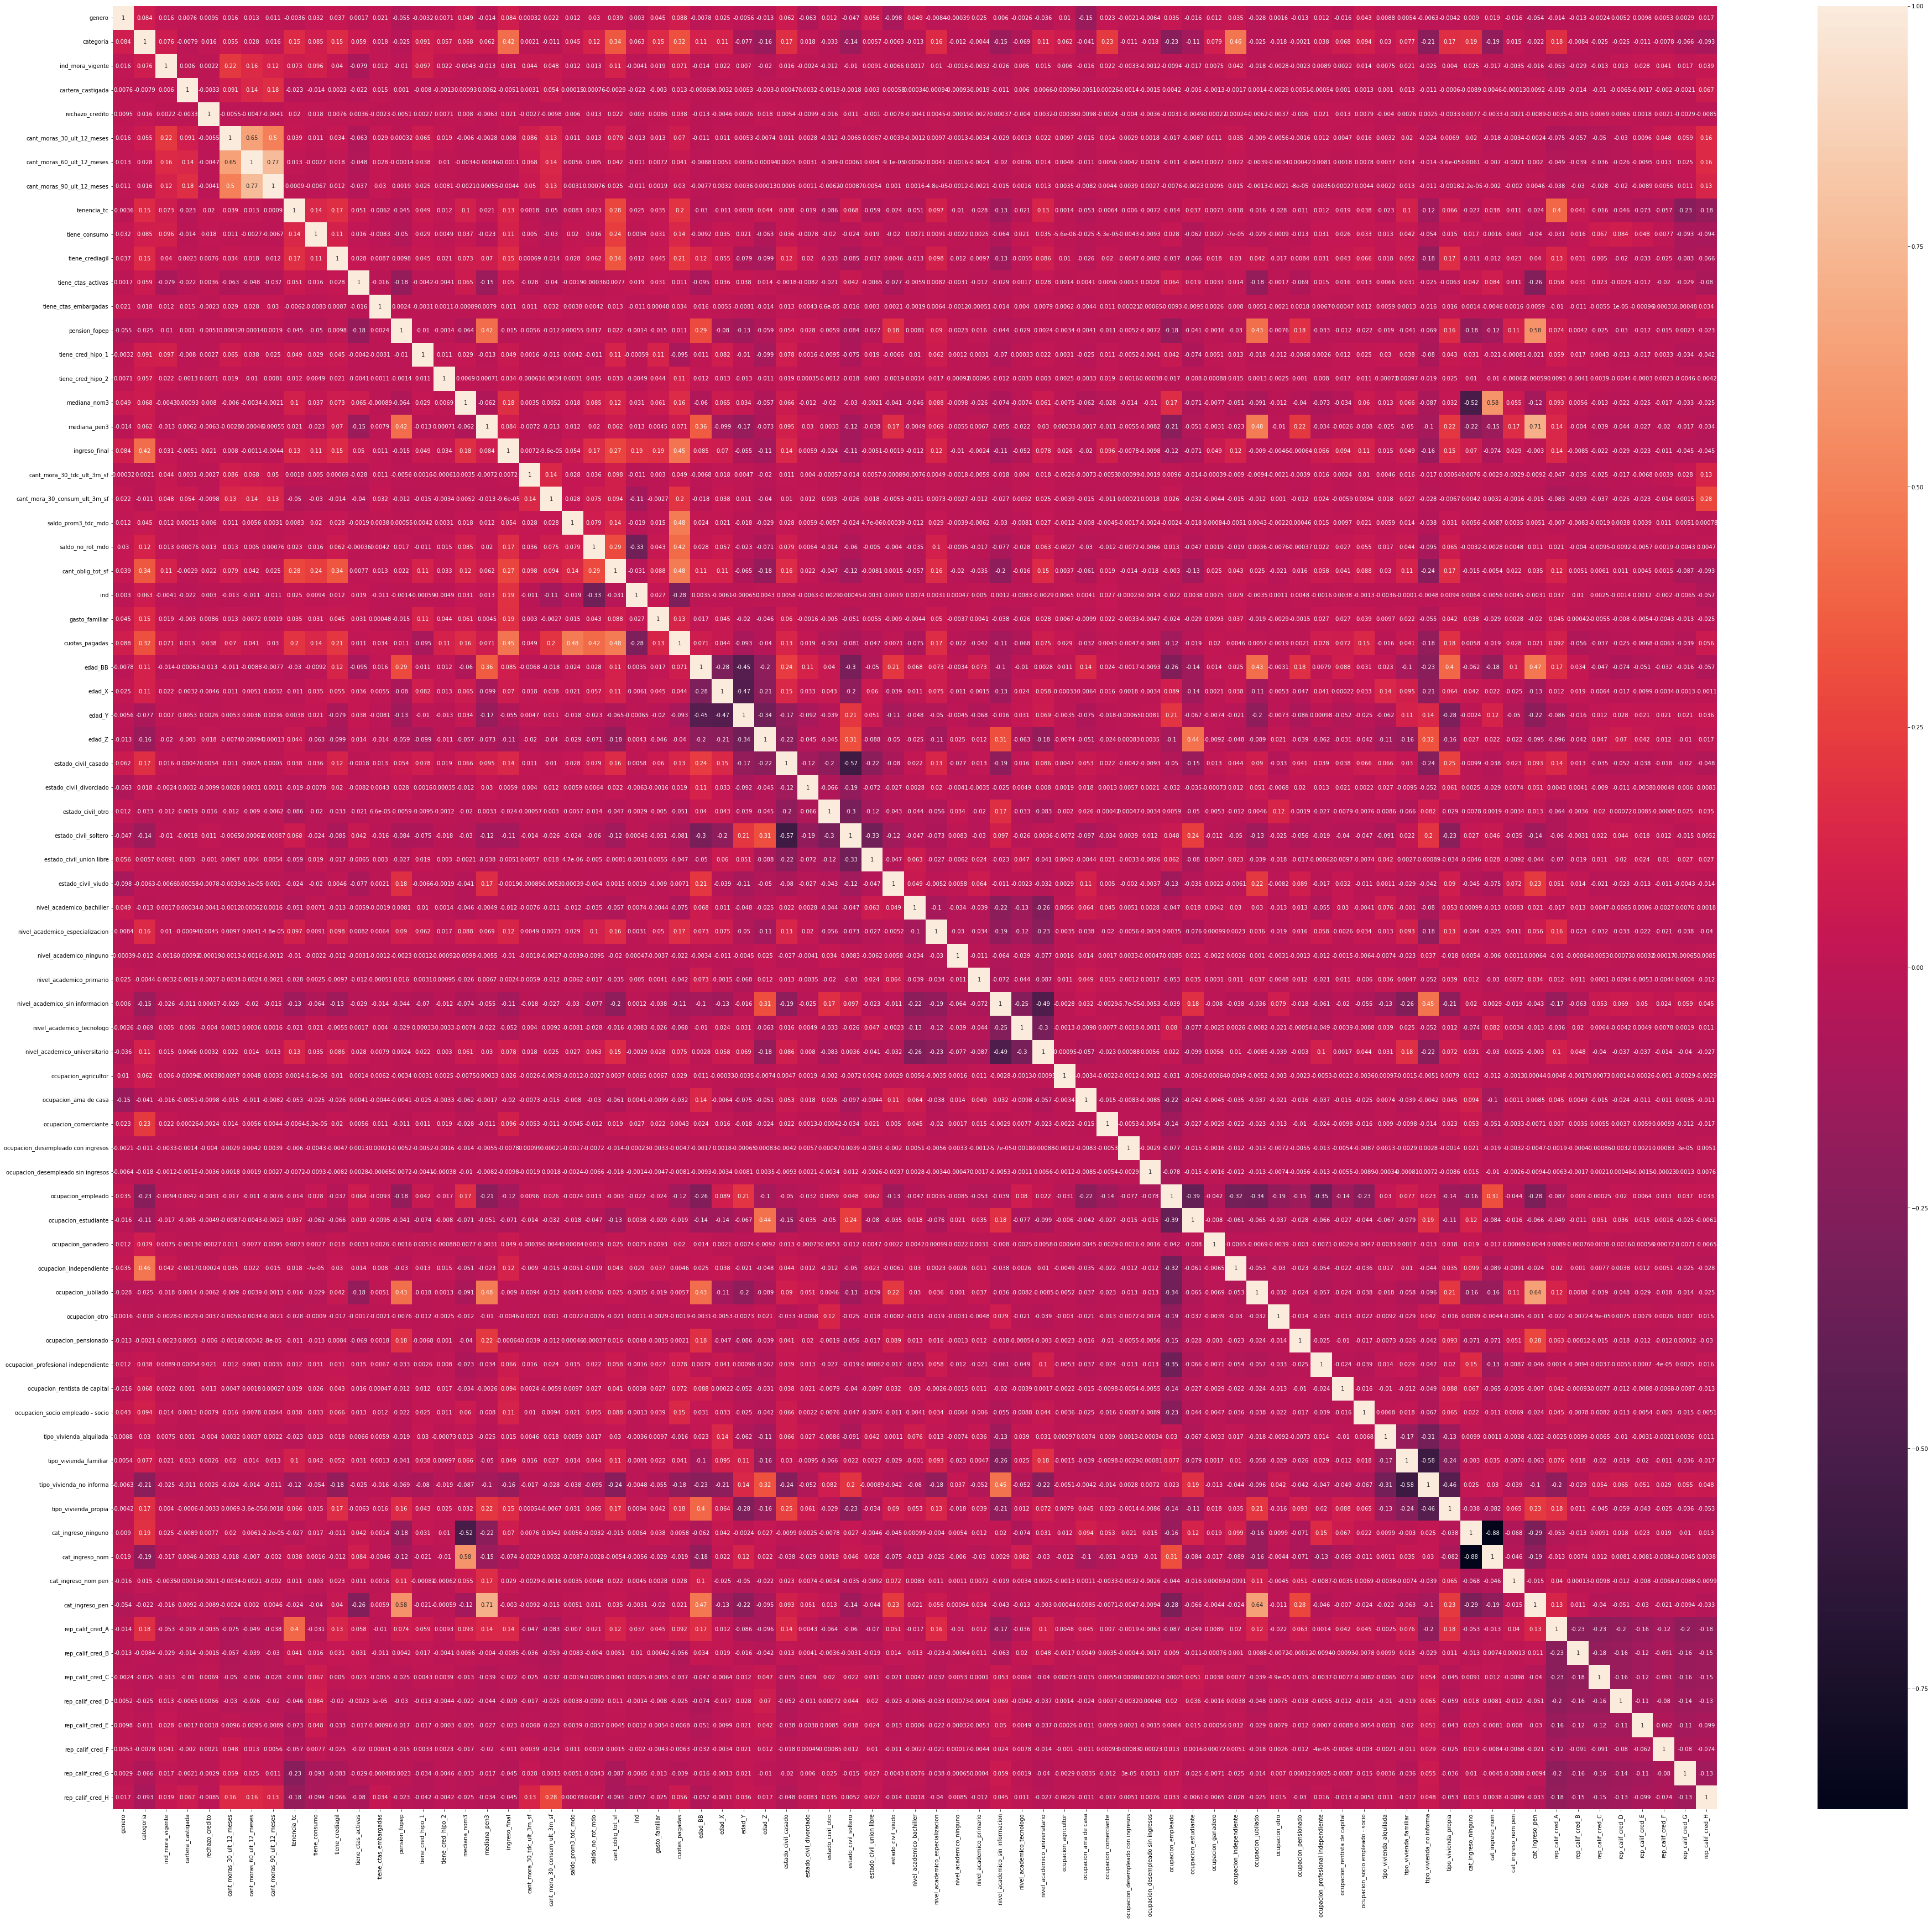

In [22]:
plt.figure(figsize = (65,60))
corrMatrix = cat_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Imputación de valores nulos

In [23]:
cat_df = cat_df.fillna(0)

### Eliminación de Outliers

In [24]:
max_val = cat_df.gasto_familiar.quantile(0.95)
min_val = cat_df.gasto_familiar.quantile(0.05)

cat_df = cat_df[(cat_df['gasto_familiar'] > min_val) & (cat_df['gasto_familiar']< max_val)]

## Modelos

In [25]:
cat_df.describe()

,genero,categoria,ind_mora_vigente,cartera_castigada,rechazo_credito,cant_moras_30_ult_12_meses,cant_moras_60_ult_12_meses,cant_moras_90_ult_12_meses,tenencia_tc,tiene_consumo,...,cat_ingreso_nom pen,cat_ingreso_pen,rep_calif_cred_A,rep_calif_cred_B,rep_calif_cred_C,rep_calif_cred_D,rep_calif_cred_E,rep_calif_cred_F,rep_calif_cred_G,rep_calif_cred_H
count,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,...,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000,422890.000000
mean,0.488385,1.469517,0.022902,0.001757,0.005439,0.019825,0.008468,0.005079,0.414143,0.134260,...,0.003528,0.060420,0.223027,0.153666,0.153692,0.122325,0.076878,0.044120,0.122297,0.103994
std,0.499866,0.776542,0.149591,0.041879,0.073547,0.139400,0.091631,0.071088,0.492574,0.340931,...,0.059293,0.238264,0.416277,0.360629,0.360654,0.327661,0.266398,0.205362,0.327628,0.305253
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Divisón del dataset

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

scoring = ["r2", "neg_mean_absolute_percentage_error"]

In [27]:
X = cat_df.drop(["gasto_familiar"], axis = 1)
Y = cat_df["gasto_familiar"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 11)

### ElasticNet

#### ElasticNect Train/Test Split (70/30)

In [79]:
ENReg = ElasticNetCV(random_state = 0)
print(ENReg)
ENReg.fit(X_train, y_train)

ElasticNetCV(random_state=0)


ElasticNetCV(random_state=0)

In [81]:
ENReg_pred = ENReg.predict(X_test)

In [82]:
print(f"R2 Score: {r2_score(y_test, ENReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, ENReg_pred)}")

R2 Score: 0.04814934216695932
MAPE Score: 101.43252013372664


#### ElasticNet con cross validate

In [84]:
scores = cross_validate(ENReg, X, Y, return_train_score = True, cv=5, scoring = scoring)

In [86]:
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.05059578654146981
Test r2 score: 0.049714518834689206
Entrenamiento nMAPE score: -107.44198274973235
Test nMAPE score: -107.56078809421649


### Gradient Boost Tree

#### GBT Train/Test (70/30)

In [31]:
GBReg = GradientBoostingRegressor(n_estimators=50, 
                                  max_depth = 6,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [28]:
GBReg_pred = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: 0.12345669192699715
MAPE Score: 79.04687848777206


In [29]:
GBReg = GradientBoostingRegressor(n_estimators=300, 
                                  max_depth = 15,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 290248567823.8345  6974869607.9065           10.40m
         2 281424852762.7626  5570006859.1243           10.33m
         3 274471141632.2471  4455428466.2596           10.36m
         4 267157406164.0435  3506792902.2435           10.28m
         5 260794966354.6179  2943035510.4823           10.27m
         6 254261773055.9709  2225302610.3926           10.20m
         7 252800018017.6689  1656423605.0911           10.19m
         8 247740019143.3701  1280743617.1734           10.18m
         9 241066371331.5717   930858798.4379           10.16m
        10 239872924160.1267   753169584.0928           10.13m
        11 237515284622.9398   424384141.2665           10.10m
        12 234331091075.7322   443156077.0604           10.08m
        13 231441980602.6523   316815859.4849           10.06m
        14 228609971213.5519   206670000.8321           10.04m
        15 227717609811.5588    84014718.2919          

In [30]:
GBReg_pred = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: 0.041077552721877963
MAPE Score: 87.5456051795059


In [29]:
GBReg = GradientBoostingRegressor(n_estimators=500, 
                                  max_depth = 30,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 259314396135.1307  5225672780.8846           26.69m
         2 236750374634.0996  4226932283.2761           26.41m
         3 218101113763.4843  3078197447.5849           26.32m
         4 201405200749.6570  2100425252.6972           26.46m
         5 185798850482.4583  1625945193.3416           26.56m
         6 172045465732.0099  1199442894.8006           26.51m
         7 161730354003.6757   339821792.1720           26.53m
         8 150120242536.0269   314927451.8648           26.58m
         9 140156559245.1725    21381366.5006           26.62m
        10 133554083643.7477   -46434465.9508           26.70m
        11 126078098151.8207  -244928107.7283           26.79m
        12 118726790699.1316  -346526567.1750           26.84m
        13 110649340319.3637  -549901538.6530           26.80m
        14 105481155965.1111  -519388325.3868           26.83m
        15 100297690314.1541  -561131321.2963          

In [30]:
GBReg_pred = GBReg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, GBReg_pred)}")
print(f"MAPE Score: {mean_absolute_percentage_error(y_test, GBReg_pred)}")

R2 Score: -0.016839592948105553
MAPE Score: 70.7241111850848


#### GBT Cross validate

##### Modelo sencillo

In [87]:
GBReg = GradientBoostingRegressor(n_estimators=50, 
                                  max_depth = 6,
                                  random_state = 101,
                                  subsample = 0.5,)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.1380759752753196
Test r2 score: 0.124359535558213
Entrenamiento nMAPE score: -111.71882303862367
Test nMAPE score: -109.09888593943761


##### Modelo de complejidad intermedia

In [88]:
GBReg = GradientBoostingRegressor(n_estimators=300, 
                                  max_depth = 15,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

Entrenamiento r2 score: 0.705088427224768
Test r2 score: 0.039646741428743006
Entrenamiento nMAPE score: -46.42999000547872
Test nMAPE score: -109.17267897293894


##### Modelo de complejidad alta

In [30]:
GBReg = GradientBoostingRegressor(n_estimators=400, 
                                  max_depth = 60,
                                  random_state = 101,
                                  subsample = 0.5,
                                  verbose = 2)

scores = cross_validate(GBReg, X, Y,return_train_score = True, cv=5, scoring = scoring)
print(f"Entrenamiento r2 score: {np.mean(scores['train_r2'])}")
print(f"Test r2 score: {np.mean(scores['test_r2'])}")
print(f"Entrenamiento nMAPE score: {np.mean(scores['train_neg_mean_absolute_percentage_error'])}")
print(f"Test nMAPE score: {np.mean(scores['test_neg_mean_absolute_percentage_error'])}")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1 249875600520.5040  4621375580.6574           33.24m
         2 222974046229.3997  3473583192.6023           32.95m
         3 199496242410.9706  2929798513.4025           32.95m
         4 179414756085.0292  1621536607.4885           33.08m
         5 162777562770.9530  1233641638.6675           33.01m
         6 146822753331.0879   494013792.2425           33.23m
         7 132026780442.6555   372971122.3062           33.37m
         8 119985039882.1569  -140999779.7207           33.61m
         9 108869457618.1896  -200587413.3930           33.80m
        10 98805421868.8116  -475599331.6837           33.89m
        11 89601204415.1988  -465644826.4067           34.11m
        12 81110303508.6499  -589450712.2552           34.38m
        13 73994111937.2269  -690898306.6848           34.47m
        14 67110806507.1138  -765914975.4013           34.68m
        15 61695019139.8299  -740102461.8331           34.80

KeyboardInterrupt: 

#### Evaluación gráfica del modelo más óptimo

In [ ]:
plt.hist(y_pred, color = "b", label = "Datos predichos");
plt.hist(y2_test, color = "g", label = "Datos reales");
plt.title("Distribución de predicciones y datos reales")

In [ ]:
residuals = y2_test - y_pred
ap_residuals = np.abs(residuals) / y2_test
lap_residuals = np.log(ap_residuals)

In [ ]:
plt.scatter(y2_test,residuals);
plt.xlabel("Predicciones")
plt.ylabel("Valor Residual")
plt.title("Residuales vs Predicciones")

In [ ]:
plt.scatter(y2_test,ap_residuals);
plt.xlabel("Predicciones")
plt.ylabel("Valor Residual")
plt.title("Residuales absoltutos vs Predicciones")

In [ ]:
plt.scatter(y2_test,lap_residuals);
plt.xlabel("Predicciones")
plt.ylabel("Valor Residual")
plt.title("Residuales logaritmicos vs Predicciones")

### Support Vector Machine (SVR)

#### SVR Train/Test Split (70/30)

##### Kernel Lineal

In [ ]:
svr = SVR(kernel = "linear", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

##### Kernel Polinomial

In [ ]:
svr = SVR(kernel = "poly", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

##### Kernel RBF

In [ ]:
svr = SVR(kernel = "rbf", C=1.0, epsilon=0.2, verbose=True)
svr.fit(X_train, y_train)

Debido a la alta complejidad del modelo, y los costos computacionales para los calculos, el SVR solo se utilizará en validación Train/Test Split